In [88]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive


In [89]:
!pip install --upgrade tensorflow -q

In [90]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [91]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.15.0


In [92]:
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler

In [93]:
use_tpu = True#@param {type:"boolean"}

if 'COLAB_TPU_ADDR' in os.environ and use_tpu:
  TF_MASTER = 'grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])
else:
  use_tpu = False


if use_tpu:
  tpu_address = TF_MASTER
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver(TF_MASTER)
  tf.config.experimental_connect_to_cluster(resolver)
  tf.tpu.experimental.initialize_tpu_system(resolver)
  strategy = tf.distribute.TPUStrategy(resolver)

In [152]:
def print_sequence(dataset, to_plot):
  figs, axs = plt.subplots(to_plot, 1, sharex=True, figsize=(17,17))
  n_elements = len(dataset)
  for i in range(to_plot):
    el = random.randrange(n_elements)
    axs[i].plot(dataset[el])
    axs[i].set_title(el)
  plt.show()

In [153]:
def build_sequences(df, window=200, stride=20, telescope=100):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    for el in range(len(df)):
      element = df[el]
      lenght = len(element)
      starting = 0
      ending_w = starting + window
      ending_t = ending_w + telescope
      while True:
        if ending_t > lenght:
          break
        dataset.append(element[starting:ending_w])
        labels.append(element[ending_w:ending_t])
        starting = starting + stride
        ending_w = starting + window
        ending_t = ending_w + telescope

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [154]:
training_data = np.load("training_data.npy", allow_pickle=True)
training_data.shape

(48000, 2776)

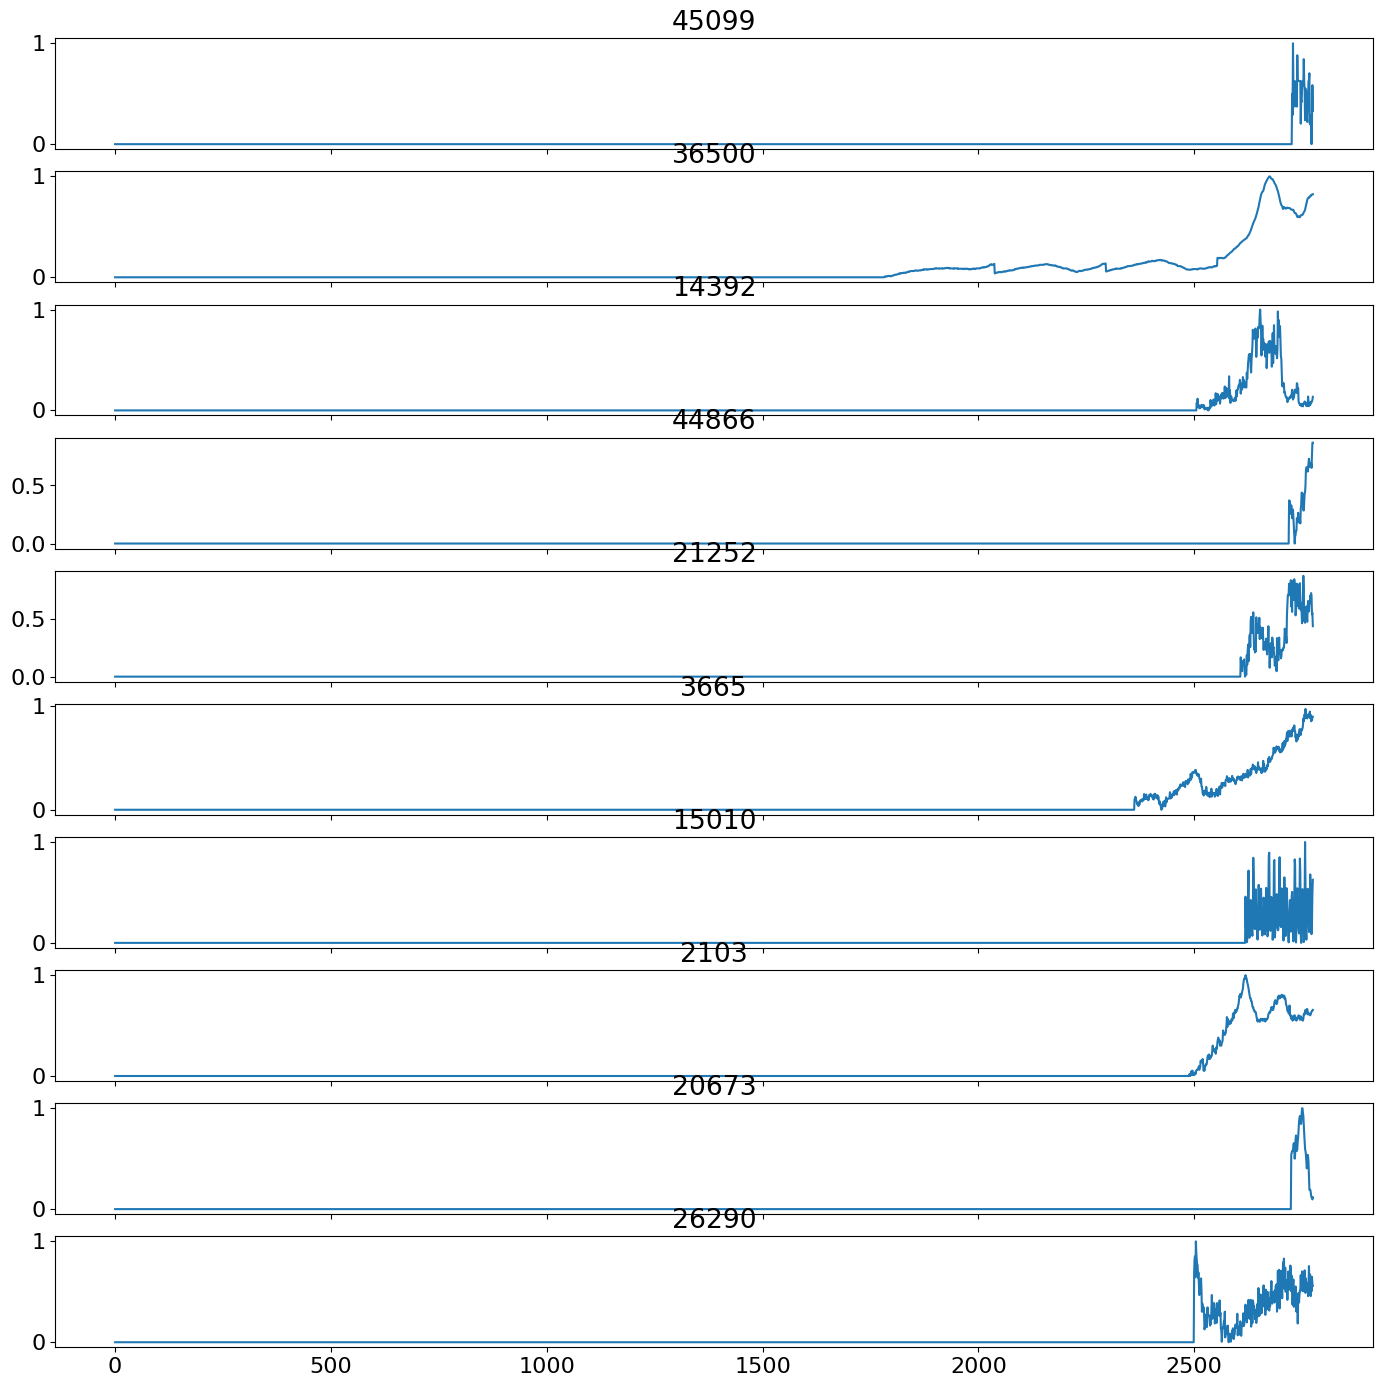

In [155]:
print_sequence(training_data, 10)

In [156]:
categories = np.load("categories.npy", allow_pickle=True)
valid_periods = np.load("valid_periods.npy", allow_pickle=True)
categories_Set = set(categories)

dataset = []
for i in range(training_data.shape[0]):
  start = valid_periods[i][0]
  ending = valid_periods[i][1]
  if ending - start >= 218:
     dataset.append(training_data[i][start : ending])


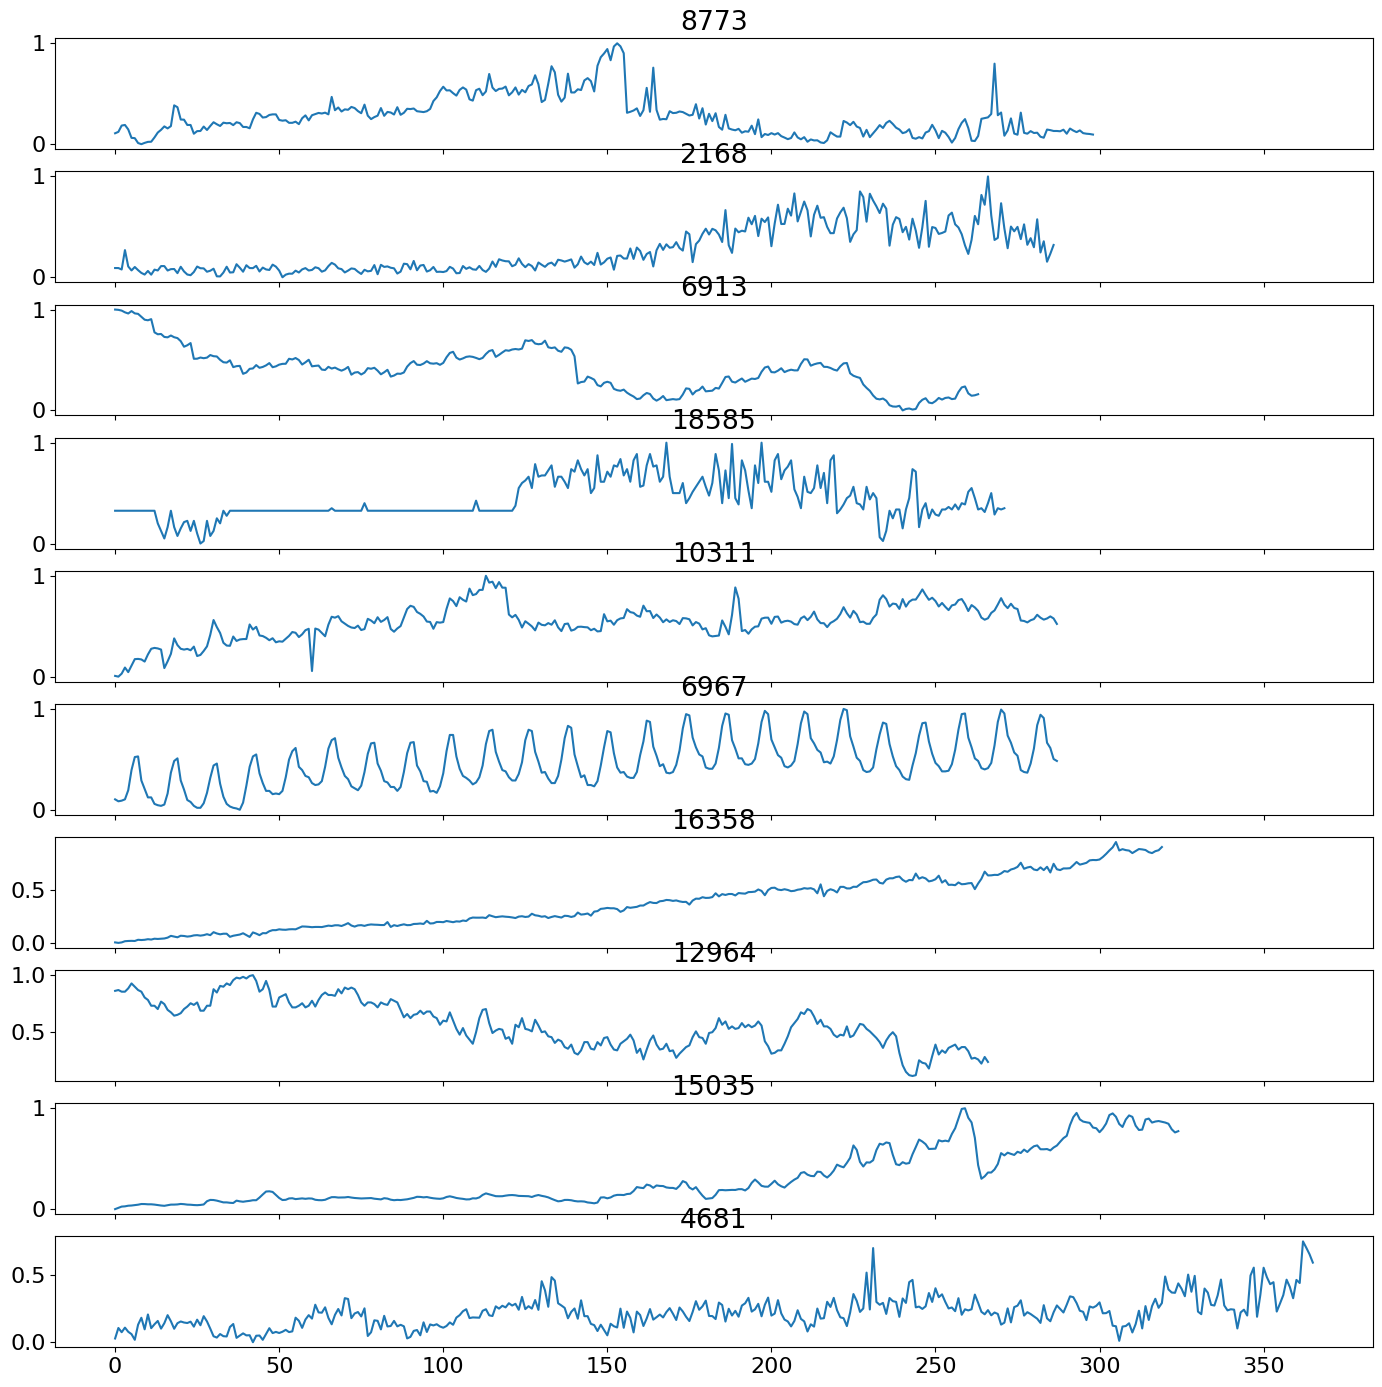

In [157]:
print_sequence(dataset, 10)

In [158]:
from sklearn.model_selection import train_test_split
X_test, X_train_val = train_test_split(dataset, test_size=0.80)
X_val, X_train = train_test_split(X_train_val, test_size=0.80)
print(len(X_train))
print(len(X_test))

12689
3965


In [159]:
window = 200
stride = 50
telescope = 18
autoregressive_telescope = 3
X_train, y_train = build_sequences(X_train, window, stride, autoregressive_telescope)
X_val, y_val = build_sequences(X_val, window, stride, autoregressive_telescope)
X_test, y_test = build_sequences(X_test, window, stride, telescope)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

(68343, 200)
(68343, 6)
(18266, 200)
(18266, 18)
(17187, 200)
(17187, 6)


In [160]:
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
y_train = np.expand_dims(y_train, axis=-1)
y_val = np.expand_dims(y_val, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)

In [161]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

In [162]:
# Assign the batch size
if use_tpu:
  BATCH_SIZE = 64
else:
  BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE

In [163]:
def prepare_trainset(dataset):
  return(
      dataset
            .cache()
            .shuffle(1000, reshuffle_each_iteration=True)
            .repeat()
            .batch(BATCH_SIZE, drop_remainder=True)
  )

def prepare_valset(dataset):
    return (
            dataset
            .cache()
            .repeat()
            .batch(BATCH_SIZE, drop_remainder=True)
        )

train_dataset = prepare_trainset(train_dataset)
val_dataset = prepare_valset(val_dataset)

In [164]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]

In [165]:
def build_CONV_LSTM_model(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Add a Bidirectional LSTM layer with 64 units
    x = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True, name='lstm'), name='bidirectional_lstm')(input_layer)

    x = tfkl.Bidirectional(tfkl.LSTM(256, return_sequences=True, name='lstm'), name='bidirectional_lstm_2')(x)

    x = tfkl.Conv1D(512, 3, padding='same', activation='relu', name='conv_1')(x)

    x = tfkl.Conv1D(256, 3, padding='same', activation='relu', name='conv_2')(x)
    # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv')(x)

    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Conv1D(output_shape[1], 3, padding='same', name='output_layer')(x)

    # Calculate the size to crop from the output to match the output shape
    crop_size = output_layer.shape[1] - output_shape[0]
    print(output_layer.shape[1])

    # Crop the output to the desired length
    output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(output_layer)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

In [166]:
if use_tpu:
  with strategy.scope():
    model = build_CONV_LSTM_model(input_shape, output_shape)
else:
  model = build_CONV_LSTM_model(input_shape, output_shape)

Model: "CONV_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 200, 1)]          0         
                                                                 
 bidirectional_lstm (Bidire  (None, 200, 128)          33792     
 ctional)                                                        
                                                                 
 conv (Conv1D)               (None, 200, 128)          49280     
                                                                 
 output_layer (Conv1D)       (None, 200, 1)            385       
                                                                 
 cropping (Cropping1D)       (None, 6, 1)              0         
                                                                 
Total params: 83457 (326.00 KB)
Trainable params: 83457 (326.00 KB)
Non-trainable params: 0 (0.00 Byte)
_____________

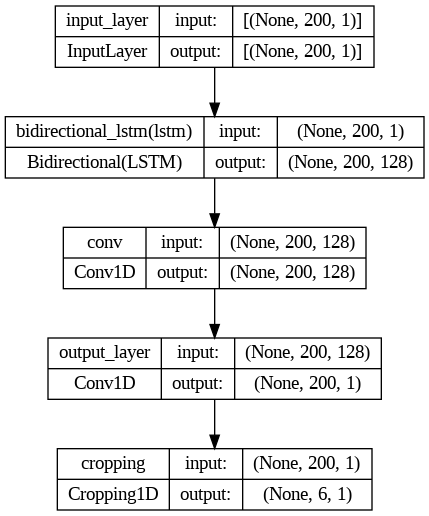

In [167]:
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    train_dataset,
    steps_per_epoch = len(X_train) // BATCH_SIZE,
    epochs = 300,
    validation_data = val_dataset,
    validation_steps = len(X_val) // BATCH_SIZE,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/300
1067/1067 [==============================] - 33s 24ms/step - loss: 0.0663 - val_loss: 0.0633 - lr: 0.0010
Epoch 2/300
1067/1067 [==============================] - 26s 25ms/step - loss: 0.0307 - val_loss: 0.0117 - lr: 0.0010
Epoch 3/300
1067/1067 [==============================] - 24s 23ms/step - loss: 0.0099 - val_loss: 0.0091 - lr: 0.0010
Epoch 4/300
1067/1067 [==============================] - 24s 23ms/step - loss: 0.0094 - val_loss: 0.0094 - lr: 0.0010
Epoch 5/300
1067/1067 [==============================] - 24s 23ms/step - loss: 0.0090 - val_loss: 0.0089 - lr: 0.0010
Epoch 6/300
1067/1067 [==============================] - 24s 22ms/step - loss: 0.0082 - val_loss: 0.0094 - lr: 0.0010
Epoch 7/300
1067/1067 [==============================] - 24s 23ms/step - loss: 0.0105 - val_loss: 0.0081 - lr: 0.0010
Epoch 8/300
1067/1067 [==============================] - 24s 22ms/step - loss: 0.0081 - val_loss: 0.0076 - lr: 0.0010
Epoch 9/300
1067/1067 [==============================] -

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
reg_predictions = np.array([])
X_temp = X_test
for reg in range(0,telescope,autoregressive_telescope):
    pred_temp = model.predict(X_temp,verbose=0)
    if(len(reg_predictions)==0):
        reg_predictions = pred_temp
    else:
        reg_predictions = np.concatenate((reg_predictions,pred_temp),axis=1)
    X_temp = np.concatenate((X_temp[:,autoregressive_telescope:,:],pred_temp), axis=1)

In [ ]:
# Print the shape of the predictions
print(f"Predictions shape: {reg_predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test_reg.flatten(), reg_predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test_reg.flatten(), reg_predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

In [ ]:
NAME_MODEL = "BidirectionalGRU"
if use_tpu:
  # save model locally from tpu using Tensorflow's "SavedModel" format
  save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
  model.save(NAME_MODEL, options=save_locally)
else:
  model.save(NAME_MODEL)